In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import norm
from functools import partial

### Enter experimental data

- Split data with ','

- For time and qt_absorbed, if there are multiple datasets, split each dataset with '\n'

In [2]:
# Input by the user
time = '0, 5, 10, 15, 20, 25, 30, 35, 40' # min
qt_absorbed = '0, 0.089904, 0.11238, 0.138602, 0.161078, 0.172316, 0.179808, 0.1873, 0.1873' # mg/g
C0_adsorbate = '8' # mg/L
Cs_adsorbent = '40' # g/L
units = 'min,mg/g,mg/L,g/L'

### Define the models and functions

In [3]:
# Zero order model
def ZO_getQ(t, k0):
    return k0 * t

def ZO_linear(t, qt):
    t1 = t.reshape(-1, 1)
    model = LinearRegression()
    model.fit(t1, qt)
    k0 = float(model.coef_[0])

    q_model = ZO_getQ(t, k0)
    r_sq = rsquared(qt, q_model)
    return k0, r_sq, q_model

# First order model
def PFO_getQ(t, qe, k1):
    return qe * (1 - np.exp(-k1 * t))

def PFO_linear(t, qt):
    qe = max(qt) * 1.01
    ln = np.log(qe - qt)
    t1 = t.reshape(-1, 1)
    model = LinearRegression()
    model.fit(t1, ln)
    c = float(model.intercept_)
    m = float(model.coef_[0])
    
    k1 = -m
    qe = np.exp(c)
    
    q_model = PFO_getQ(t, qe, k1)
    r_sq = rsquared(qt, q_model)
    return qe, k1, r_sq, q_model

def PFO_nonlinear(t, qt):
    p1, p2, _, _ = PFO_linear(t, qt)
    p0 = np.array([p1,p2])
    popt, pcov = curve_fit(PFO_getQ, t, qt, p0=p0, maxfev=1000000)
    qe, k1 = popt

    q_model = PFO_getQ(t, qe, k1)
    r_sq = rsquared(qt, q_model)
    return qe, k1, r_sq, q_model

# Second order model
def PSO_getQ(t, qe, k2):
    return t / ((t / qe) + (1 / (k2 * qe**2)))

def PSO_linear(t, qt):
    t_qt = t[1:] / qt[1:]
    t1 = t.reshape(-1,1)
    model = LinearRegression()
    model.fit(t1[1:], t_qt)
    c = float(model.intercept_)
    m = float(model.coef_[0])

    qe = 1/m
    k2 = 1/(c*qe*qe)

    q_model = PSO_getQ(t, qe, k2)
    r_sq = rsquared(qt, q_model)
    return qe, k2, r_sq, q_model

def PSO_nonlinear(t, qt):
    p1, p2, _, _ = PSO_linear(t, qt)
    p0 = np.array([p1, p2])
    popt, pcov = curve_fit(PSO_getQ, t, qt, p0=p0, maxfev=1000000)
    qe, k2 = popt

    q_model = PSO_getQ(t, qe, k2)
    r_sq = rsquared(qt, q_model)
    return qe, k2, r_sq, q_model

def rPSO_getQ(t, qe, kprime, C0, Cs):
    dt = t[-1] / 1000
    t1 = np.arange(0, t[-1]+dt, dt)
    t_model = np.array(t * (1/dt), 'i')
    q = np.zeros(len(t1), dtype='float')
    q_model = []
    for i in range(1, len(t1)):
        q[i] = q[i-1] + (dt * (kprime * (C0 - Cs * q[i-1]) * (1 - q[i-1] / qe)**2))
    for j in t_model:
        q_model.append(q[j])
    return q_model

def rPSO_nonlinear(t, qt, C0, Cs):
    p1, p2, _, _ = PSO_nonlinear(t, qt)
    p0 = np.array([p1, p2 * p1**2 / C0])

    rPSO_getQ_fixed = partial(rPSO_getQ, C0=C0, Cs=Cs)
    popt, pcov = curve_fit(rPSO_getQ_fixed, t, qt, p0=p0, maxfev=1000000)
    qe, kprime = popt

    q_model = rPSO_getQ(t, qe, kprime, C0, Cs)
    r_sq = rsquared(qt, q_model)
    return qe, kprime, r_sq, q_model

# Multiple datasets
def ini_rate(t, qt):
    r = np.zeros(len(qt))
    for i in range(len(qt)):
        r[i] = qt[i][1] / t[i][1]
    return r

def order_analysis(r, C0):
    ini_conc = C0.reshape(-1, 1)
    ini_rates = r.reshape(-1, 1)
    model = LinearRegression()
    model.fit(np.log(ini_conc), np.log(ini_rates))
    order = float(model.coef_[0][0])
    r_pred = model.predict(np.log(ini_conc))
    return order, r_pred

# Model analysis
def rsquared(qt, q_model):
    return 1 - np.sum((qt - q_model)**2) / np.sum((qt - np.mean(qt))**2)

def error_analysis(t, qt, q_model, order, func, C0=None, Cs=None):
    sse = np.sum(np.square(q_model - qt))
    std = np.sqrt(sse/(len(qt)-2))
    if order == 0:
        k_list = np.zeros(100)
        for i in range(100):
            q_sim = q_model + norm.ppf(np.random.rand(len(qt)), 0, std)
            k_list[i], _, _ = func(t, q_sim)
        k_list = sorted(k_list)
        k_err = (k_list[94] - k_list[5]) / 2
        qe_err = None
    elif func == rPSO_nonlinear:
        qe_list = np.zeros(100)
        k_list = np.zeros(100)
        for i in range(100):
            q_sim = q_model + norm.ppf(np.random.rand(len(qt)), 0, std)
            qe_list[i], k_list[i], _, _ = func(t, q_sim, C0, Cs)
        qe_list = sorted(qe_list)
        k_list = sorted(k_list)
        qe_err = (qe_list[94] - qe_list[5]) / 2
        k_err = (k_list[94] - k_list[5]) / 2
    else:
        qe_list = np.zeros(100)
        k_list = np.zeros(100)
        for i in range(100):
            q_sim = q_model + norm.ppf(np.random.rand(len(qt)), 0, std)
            qe_list[i], k_list[i], _, _ = func(t, q_sim)
        qe_list = sorted(qe_list)
        k_list = sorted(k_list)
        qe_err = (qe_list[94] - qe_list[5]) / 2
        k_err = (k_list[94] - k_list[5]) / 2
    return qe_err, k_err

# Result visualisation
def plot_single_data(t, qt, C0, Cs, params, units):
    t_model = np.linspace(0, max(t)*1.1, 100)
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs[0,0].scatter(t, qt, label = 'experimental')
    axs[0,0].plot(t_model, ZO_getQ(t_model, params[0]), label = 'model')
    axs[0,0].legend(loc='lower right')
    axs[0,0].set_xlabel(f'Time t ({units[0]})')
    axs[0,0].set_ylabel(f'Absorbate concentration qt ({units[1]})')
    axs[0,0].set_title('linear ZO')
    axs[0,1].scatter(t, qt, label = 'experimental')
    axs[0,1].plot(t_model, PFO_getQ(t_model, params[1], params[2]), label = 'model')
    axs[0,1].legend(loc='lower right')
    axs[0,1].set_xlabel(f'Time t ({units[0]})')
    axs[0,1].set_ylabel(f'Absorbate concentration qt ({units[1]})')
    axs[0,1].set_title('linear PFO')
    axs[0,2].scatter(t, qt, label = 'experimental')
    axs[0,2].plot(t_model, PFO_getQ(t_model, params[3], params[4]), label = 'model')
    axs[0,2].legend(loc='lower right')
    axs[0,2].set_xlabel(f'Time t ({units[0]})')
    axs[0,2].set_ylabel(f'Absorbate concentration qt ({units[1]})')
    axs[0,2].set_title('nonlinear PFO')
    axs[1,0].scatter(t, qt, label = 'experimental')
    axs[1,0].plot(t_model, PSO_getQ(t_model, params[5], params[6]), label = 'model')
    axs[1,0].legend(loc='lower right')
    axs[1,0].set_xlabel(f'Time t ({units[0]})')
    axs[1,0].set_ylabel(f'Absorbate concentration qt ({units[1]})')
    axs[1,0].set_title('linear PSO')
    axs[1,1].scatter(t, qt, label = 'experimental')
    axs[1,1].plot(t_model, PSO_getQ(t_model, params[7], params[8]), label = 'model')
    axs[1,1].legend(loc='lower right')
    axs[1,1].set_xlabel(f'Time t ({units[0]})')
    axs[1,1].set_ylabel(f'Absorbate concentration qt ({units[1]})')
    axs[1,1].set_title('nonlinear PSO')
    axs[1,2].scatter(t, qt, label = 'experimental')
    axs[1,2].plot(t_model, rPSO_getQ(t_model, params[9], params[10], C0, Cs), label = 'model')
    axs[1,2].legend(loc='lower right')
    axs[1,2].set_xlabel(f'Time t ({units[0]})')
    axs[1,2].set_ylabel(f'Absorbate concentration qt ({units[1]})')
    axs[1,2].set_title('nonlinear rPSO')
    plt.tight_layout()

def plot_multi_data(t, qt, C0, ini_rate, order, r_pred, params, units):
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs[0].scatter(np.log(C0), np.log(ini_rate))
    axs[0].plot(np.log(C0), r_pred)
    axs[0].set_xlabel(f'log C0 ({units[2]})')
    axs[0].set_ylabel(f'log rate ({units[4]})')
    axs[0].set_title('Initial Rate vs. Initial Concentration')
    if round(order) == 0:
        for i in range(len(qt)):
            t_model = np.linspace(0, max(t[i])*1.1, 100)
            axs[1].scatter(t[i], qt[i], label = f'experimental data_{i+1} ')
            axs[1].plot(t_model, ZO_getQ(t_model, params[i]), label = f'model data_{i+1} ')
        axs[1].legend(loc='lower right')
        axs[1].set_xlabel(f'Time t ({units[0]})')
        axs[1].set_ylabel(f'Absorbate concentration qt ({units[1]})')
        axs[1].set_title('linear ZO')
    elif round(order) == 1:
        for i in range(len(qt)):
            t_model = np.linspace(0, max(t[i])*1.1, 100)
            axs[1].scatter(t[i], qt[i], label = f'experimental data_{i+1}')
            axs[1].plot(t_model, PFO_getQ(t_model, params[2*i], params[2*i+1]), label = f'model data_{i+1}')
        axs[1].legend(loc='lower right')
        axs[1].set_xlabel(f'Time t ({units[0]})')
        axs[1].set_ylabel(f'Absorbate concentration qt ({units[1]})')
        axs[1].set_title('nonlinear PFO')
    elif round(order) == 2:
        for i in range(len(qt)):
            t_model = np.linspace(0, max(t[i])*1.1, 100)
            axs[1].scatter(t[i], qt[i], label = f'experimental data_{i+1}')
            axs[1].plot(t_model, PSO_getQ(t_model, params[2*i], params[2*i+1]), label = f'model data_{i+1}')
        axs[1].legend(loc='lower right')
        axs[1].set_xlabel(f'Time t ({units[0]})')
        axs[1].set_ylabel(f'Absorbate concentration qt ({units[1]})')
        axs[1].set_title('nonlinear PSO')
    else:
        for i in range(len(qt)):
            axs[1].scatter(t[i], qt[i], label = f'dataset{i+1}')
        axs[1].legend(loc='lower right')
        axs[1].set_xlabel(f'Time t ({units[0]})')
        axs[1].set_ylabel(f'Absorbate concentration qt ({units[1]})')
        axs[1].set_title('experimental data')
    plt.tight_layout()

### Run calculations

In [4]:
def run(time, qt_absorbed, C0_adsorbate, Cs_adsorbent, unit):
    t = [np.array(list(map(float, x.split(',')))) for x in time.split('\n')]
    qt = [np.array(list(map(float, x.split(',')))) for x in qt_absorbed.split('\n')]
    C0 = np.array(list(map(float,C0_adsorbate.split(","))))
    Cs = np.array(list(map(float,Cs_adsorbent.split(","))))
    unit_input = unit.split(',')
    units = ['min', 'mg/g', 'mg/L', 'g/L']
    for i in range(4):
        if unit_input[i]:
            units[i] = unit_input[i]

    if len(t) == len(qt) and all(t[i].shape == qt[i].shape for i in range(len(qt))) and len(qt) == len(C0):
        if len(qt) == 1:
            k0, r_sq0, q_model0 = ZO_linear(t[0], qt[0])
            qe1_l, k1_l, r_sq1_l, q_model1_l = PFO_linear(t[0], qt[0])
            qe1_n, k1_n, r_sq1_n, q_model1_n = PFO_nonlinear(t[0], qt[0])
            qe2_l, k2_l, r_sq2_l, q_model2_l = PSO_linear(t[0], qt[0])
            qe2_n, k2_n, r_sq2_n, q_model2_n = PSO_nonlinear(t[0], qt[0])
            qe2_r, k2_r, r_sq2_r, q_model2_r = rPSO_nonlinear(t[0], qt[0], C0[0], Cs[0])

            _, k0_err = error_analysis(t[0], qt[0], q_model0, 0, ZO_linear)
            qe1_err_l, k1_err_l = error_analysis(t[0], qt[0], q_model1_l, 1, PFO_linear)
            qe1_err_n, k1_err_n = error_analysis(t[0], qt[0], q_model1_n, 1, PFO_nonlinear)
            qe2_err_l, k2_err_l = error_analysis(t[0], qt[0], q_model2_l, 2, PSO_linear)
            qe2_err_n, k2_err_n = error_analysis(t[0], qt[0], q_model2_n, 2, PSO_nonlinear)
            qe2_err_r, k2_err_r = error_analysis(t[0], qt[0], q_model2_r, 2, rPSO_nonlinear, C0[0], Cs[0])

            params = [k0, qe1_l, k1_l, qe1_n, k1_n, qe2_l, k2_l, qe2_n, k2_n, qe2_r, k2_r]
            r_sq = [r_sq0, r_sq1_l, r_sq1_n, r_sq2_l, r_sq2_n, r_sq2_r]
            if max(r_sq) == r_sq[0]:
                result = f'This reaction is best simulated with linear ZO model - zero order with respect to adsorbate.\nModel parameters:\nk0: {k0:.6f} +- {k0_err:.6f} {units[1]}{units[0]}-1\nR^2: {r_sq0:.6f}\n'
            elif max(r_sq) == r_sq[1]:
                result = f'This reaction is best simulated with linear PFO model - first order with respect to adsorbate.\nModel parameters:\nk1: {k1_l:.6f} +- {k1_err_l:.6f} {units[0]}-1\nqe: {qe1_l:.6f} +- {qe1_err_l:.6f} {units[1]}\nR^2: {r_sq1_l:.6f}\n'
            elif max(r_sq) == r_sq[2]:
                result = f'This reaction is best simulated with nonlinear PFO model - first order with respect to adsorbate.\nModel parameters:\nk1: {k1_n:.6f} +- {k1_err_n:.6f} {units[0]}-1\nqe: {qe1_n:.6f} +- {qe1_err_n:.6f} {units[1]}\nR^2: {r_sq1_n:.6f}\n'
            elif max(r_sq) == r_sq[3]:
                result = f'This reaction is best simulated with linear PSO model - second order with respect to adsorbate.\nModel parameters:\nk2: {k2_l:.6f} +- {k2_err_l:.6f} ({units[1]})-1{units[0]}-1\nqe: {qe2_l:.6f} +- {qe2_err_l:.6f} {units[1]}\nR^2: {r_sq2_l:.6f}\n'
            elif max(r_sq) == r_sq[4]:
                result = f'This reaction is best simulated with nonlinear PSO model - second order with respect to adsorbate.\nModel parameters:\nk2: {k2_n:.6f} +- {k2_err_n:.6f} ({units[1]})-1{units[0]}-1\nqe: {qe2_n:.6f} +- {qe2_err_n:.6f} {units[1]}\nR^2: {r_sq2_n:.6f}\n'
            else:
                result = f'This reaction is best simulated with nonlinear rPSO model - second order with respect to adsorbate.(initial concentrations taken into account)\nModel parameters:\nk2: {k2_r:.6f} +- {k2_err_r:.6f} ({units[1]})-1{units[0]}-1\nqe: {qe2_r:.6f} +- {qe2_err_r:.6f} {units[1]}\nR^2: {r_sq2_r:.6f}\n'

            table = [
                ['Model            ', 'k      ', 'qe     ', 'R^2'], 
                ['Linear ZO      ', f'{k0:.6f} +- {k0_err:.6f}', '   /   ', f'{r_sq0:.6f}'], 
                ['Linear PFO     ', f'{k1_l:.6f} +- {k1_err_l:.6f}', f'{qe1_l:.6f} +- {qe1_err_l:.6f}', f'{r_sq1_l:.6f}'], 
                ['Nonlinear PFO', f'{k1_n:.6f} +- {k1_err_n:.6f}', f'{qe1_n:.6f} +- {qe1_err_n:.6f}', f'{r_sq1_n:.6f}'], 
                ['Linear PSO     ', f'{k2_l:.6f} +- {k2_err_l:.6f}', f'{qe2_l:.6f} +- {qe2_err_l:.6f}', f'{r_sq2_l:.6f}'], 
                ['Nonlinear PSO', f'{k2_n:.6f} +- {k2_err_n:.6f}', f'{qe2_n:.6f} +- {qe2_err_n:.6f}', f'{r_sq2_n:.6f}'], 
                ['Nonlinear rPSO', f'{k2_r:.6f} +- {k2_err_r:.6f}', f'{qe2_r:.6f} +- {qe2_err_r:.6f}', f'{r_sq2_r:.6f}']
                ]
            data = "\n".join(" | ".join(row) for row in table)
            plot_single_data(t[0], qt[0], C0[0], Cs[0], params, units)

        else:
            ini_rates = ini_rate(t, qt)
            order, r_pred = order_analysis(ini_rates, C0)

            params = []
            if round(order) == 0:
                result = f'rate = k[adsorbate]^{order:.2f}\nZero order model is applied to simulate the data.\n'
                table = [['dataset', f'k0 ({units[1]}{units[0]}-1)', 'R^2']]
                for i in range(len(qt)):
                    k0, r_sq, q_model = ZO_linear(t[i], qt[i])
                    params.append(k0)
                    _, k0_err = error_analysis(t[i], qt[i], q_model, 0, ZO_linear)
                    table.append([f'{i+1}', f'{k0:.6f} +- {k0_err:.6f}', f'{r_sq:.6f}'])
                data = "\n".join(" | ".join(row) for row in table)
            elif round(order) == 1:
                result = f'rate = k[adsorbate]^{order:.2f}\nNonlinear PFO model is applied to simulate the data.\n'
                table = [['dataset', f'k1 ({units[0]}-1)', f'qe ({units[1]})', 'R^2']]
                for i in range(len(qt)):
                    qe, k1, r_sq, q_model = PFO_nonlinear(t[i], qt[i])
                    params.append(qe)
                    params.append(k1)
                    qe_err, k1_err = error_analysis(t[i], qt[i], q_model, 1, PFO_nonlinear)
                    table.append([f'{i+1}', f'{k1:.6f} +- {k1_err:.6f}', f'{qe:.6f} +- {qe_err:.6f}', f'{r_sq:.6f}'])
                data = "\n".join(" | ".join(row) for row in table)
            elif round(order) == 2:
                result = f'rate = k[adsorbate]^{order:.2f}\nNonlinear PSO model is applied to simulate the data.\n'
                table = [['dataset', f'k2 (({units[1]})-1{units[0]}-1)', f'qe ({units[1]})', 'R^2']]
                for i in range(len(qt)):
                    qe, k2, r_sq, q_model = PSO_nonlinear(t[i], qt[i])
                    params.append(qe)
                    params.append(k2)
                    qe_err, k2_err = error_analysis(t[i], qt[i], q_model, 2, PSO_nonlinear)
                    table.append([f'{i+1}', f'{k2:.6f} +- {k2_err:.6f}', f'{qe:.6f} +- {qe_err:.6f}', f'{r_sq:.6f}'])
                data = "\n".join(" | ".join(row) for row in table)
            else:
                result = f'rate = k[adsorbate]^{order:.2f}\nBeyond our availability.'
                data = None
                
            units.append(f'{units[1]} {units[0]}-1')
            plot_multi_data(t, qt, C0, ini_rates, order, r_pred, params, units)
            
        print(result)
        print(data)
    
    else:
        print('Invalid input! Please enter again.')

This reaction is best simulated with nonlinear PSO model - second order with respect to adsorbate.
Model parameters:
k2: 0.448541 +- 0.094062 (mg/g)-1min-1
qe: 0.234748 +- 0.012730 mg/g
R^2: 0.993592

Model             | k       | qe      | R^2
Linear ZO       | 0.004033 +- 0.002661 |    /    | -0.121402
Linear PFO      | 0.118927 +- 0.040975 | 0.235734 +- 0.170827 | 0.398544
Nonlinear PFO | 0.098439 +- 0.017354 | 0.189363 +- 0.009335 | 0.987352
Linear PSO      | 0.453010 +- 0.113673 | 0.234399 +- 0.014738 | 0.993581
Nonlinear PSO | 0.448541 +- 0.094062 | 0.234748 +- 0.012730 | 0.993592
Nonlinear rPSO | 0.003048 +- 0.000592 | 0.563934 +- 0.346876 | 0.992957


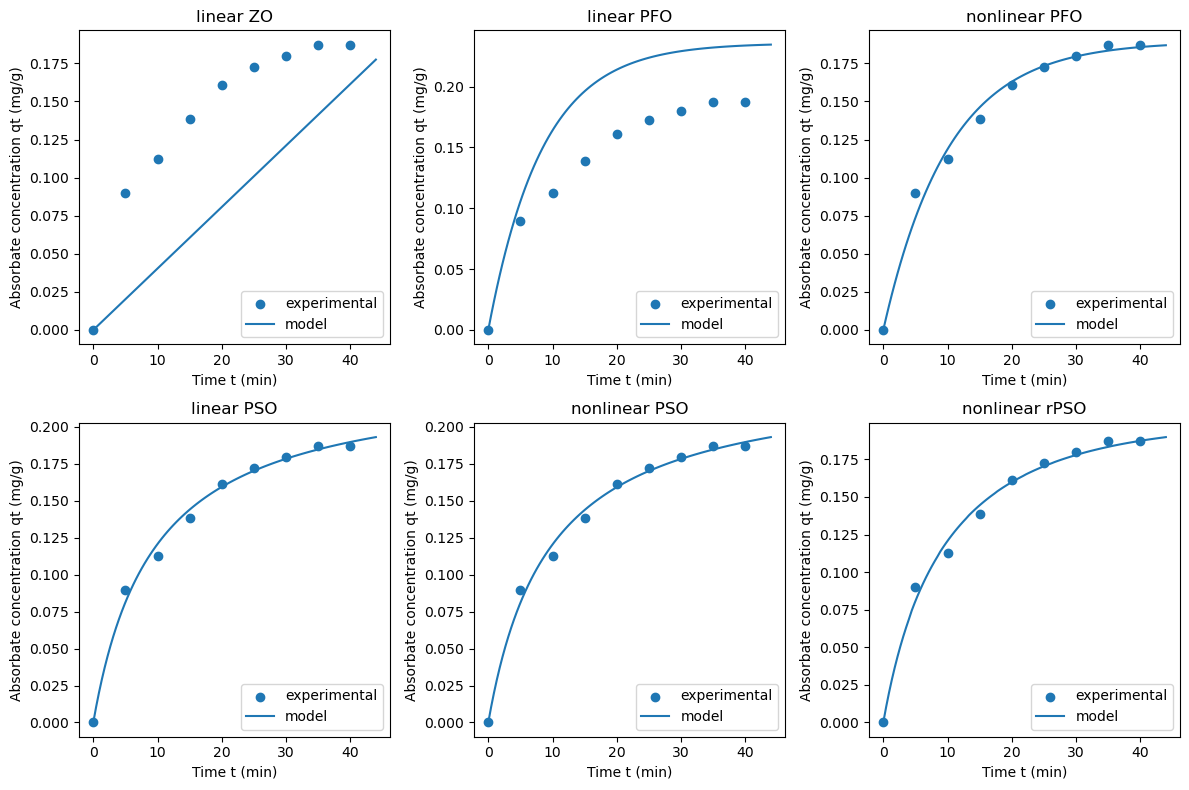

In [5]:
run(time, qt_absorbed, C0_adsorbate, Cs_adsorbent, units)